<a href="https://colab.research.google.com/github/Muawizodux/Multi-class-Segmentation-and-Classification-for-Skin-Disease/blob/main/pix2pix-GANs/Pix2Pix_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from tqdm import tqdm
import config # upload manually
import utils # upload manually
from google.colab.patches import cv2_imshow

In [ ]:
import torch.nn.functional as F

In [ ]:
def show_tensor(tensor, channel=1, size=(28, 28), num=25):
  img_data = tensor.detach().cpu().view(-1, channel, *size)
  grid = make_grid(img_data[:num] * 0.5 + 0.5, nrows=4).permute(1, 2, 0)
  plt.imshow(grid)
  plt.show()

### **Pix2Pix Generative Adversarial Network (Pix2pix GAN)**

* `Discriminator: ` Patch-GAN
* `Generator: ` U-net

In [ ]:
# Discriminator
class CNN_BLOCK(nn.Module):
  def __init__(self, in_channels, out_channels, stride=2):
    super().__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 4, stride, bias=False, padding_mode='reflect'),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2)
    )

  def forward(self, x):
    return self.conv(x)

class Discriminator(nn.Module):
  def __init__(self, in_features=3, out_features=[64, 128, 256, 512]):
    super(Discriminator, self).__init__()

    # Patch-GAN: Using patches of images with a stride 2
    self.initial = nn.Sequential(
        nn.Conv2d(in_features*2, out_features[0], 4, stride=2, padding=1, padding_mode='reflect'),
        nn.LeakyReLU(0.2)
    )

    layers = []
    in_channels= out_features[0]
    for features in out_features[1:]:
      layers.append(
          CNN_BLOCK(in_channels, features, stride = 1 if features == out_features[-1] else 2)
      )
      in_channels = features

    layers.append(
        nn.Conv2d(in_channels, 1, 4, stride=1, padding=1, padding_mode='reflect')
    )
    self.model = nn.Sequential(*layers)

  def forward(self, x, y):
    x = torch.cat([x, y], dim=1) # across channels
    x = self.initial(x)
    return self.model(x)

In [ ]:
# Testing
x = torch.rand(5, 3, 286, 286)
y = torch.rand(5, 3, 286, 286)
model = Discriminator()
test_var = model(x, y)
test_var.shape

torch.Size([5, 1, 30, 30])

In [ ]:
model

Discriminator(
  (initial): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (model): Sequential(
    (0): CNN_BLOCK(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), bias=False, padding_mode=reflect)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (1): CNN_BLOCK(
      (conv): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), bias=False, padding_mode=reflect)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (2): CNN_BLOCK(
      (conv): Sequential(
        (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), bias=False, padding_mode=reflect)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=

In [ ]:
# Generator
class Block(nn.Module):
  def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
    super().__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode='reflect') if down
        else
        nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU() if act=="relu" else nn.LeakyReLU(0.2)
    )
    self.use_dropout = use_dropout
    self.dropout = nn.Dropout(0.5)

  def forward(self, x):
    x = self.conv(x)
    return self.dropout(x) if self.use_dropout else x

class Generator(nn.Module):
  def __init__(self, in_channels = 3, features = 64):
    super().__init__()
    # U-net Downward Contraction path:
    self.initial = nn.Sequential(
        nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode='reflect'),
        nn.LeakyReLU(0.2)
    )
    self.down1 = Block(features, features*2, act="leaky")
    self.down2 = Block(features*2, features*4, act="leaky")
    self.down3 = Block(features*4, features*8, act="leaky")
    self.down4 = Block(features*8, features*8, act="leaky")
    self.down5 = Block(features*8, features*8, act="leaky")
    self.down6 = Block(features*8, features*8, act="leaky")
    self.bottleneck = nn.Sequential(
        nn.Conv2d(features*8, features*8, 4, 2, 1, padding_mode='reflect'),
        nn.ReLU()
    )

    # U-net Upward Expansion path:
    self.up1 = Block(features*8, features*8, down=False, use_dropout=True)
    self.up2 = Block(features*8*2, features*8, down=False, use_dropout=True)
    self.up3 = Block(features*8*2, features*8, down=False, use_dropout=True)
    self.up4 = Block(features*8*2, features*8, down=False, use_dropout=True)
    self.up5 = Block(features*8*2, features*4, down=False, use_dropout=True)
    self.up6 = Block(features*4*2, features*2, down=False, use_dropout=True)
    self.up7 = Block(features*2*2, features, down=False, use_dropout=True)
    self.final_up = nn.Sequential(
        nn.ConvTranspose2d(features*2, in_channels, 4, 2, 1),
        nn.Tanh()
    )

  def forward(self, x):
    d1 = self.initial(x)
    d2 = self.down1(d1)
    d3 = self.down2(d2)
    d4 = self.down3(d3)
    d5 = self.down4(d4)
    d6 = self.down5(d5)
    d7 = self.down6(d6)
    bottleneck = self.bottleneck(d7)
    up1 = self.up1(bottleneck)
    up2 = self.up2(torch.cat([up1, d7], dim=1))
    up3 = self.up3(torch.cat([up2, d6], dim=1))
    up4 = self.up4(torch.cat([up3, d5], dim=1))
    up5 = self.up5(torch.cat([up4, d4], dim=1))
    up6 = self.up6(torch.cat([up5, d3], dim=1))
    up7 = self.up7(torch.cat([up6, d2], dim=1))
    return self.final_up(torch.cat([up7, d1], dim=1))

In [ ]:
# Testing
x = torch.randn(5, 3, 256, 256)
model = Generator()
test_var = model(x)
test_var.shape

torch.Size([5, 3, 256, 256])

In [ ]:
model

Generator(
  (initial): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (down1): Block(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (down2): Block(
    (conv): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (down3): Block(
    (conv): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding

#### **Dataset Prepration**
`Non_Melanoma Skin Cancer`

In [ ]:
non_melanoma_data = np.load('/content/drive/MyDrive/pix2pix/Preprocessed_data_v2.npy')

In [ ]:
# Dataset
class MapDataset(nn.Module):
  def __init__(self, data: np.ndarray):
    self.data = data

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    # image = np.array(Image.open(image_path)) # so we can actually apply albumentations
    image = self.data[index]

    # Dont have dataset images this way: --> BGR to RGB conversion because opencv was used for loading images
    input_image = image[:, :256, :][:, :, [2, 1, 0]]
    target_image = image[:, 256:, :][:, :, [2, 1, 0]]
    # --------------------------------------

    augmentations = config.both_transforms(image=input_image, image0=target_image)
    input_image, target_image = augmentations['image'], augmentations['image0']

    input_image = config.transform_only_input(image=input_image)["image"]
    target_image = config.transform_only_mask(image=target_image)["image"]

    return input_image, target_image

In [ ]:
train_dataset = MapDataset(non_melanoma_data[:1300, :, :, :])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=config.NUM_WORKERS)

In [ ]:
image, label = next(iter(train_loader))
image.shape, label.shape

(torch.Size([16, 3, 256, 256]), torch.Size([16, 3, 256, 256]))

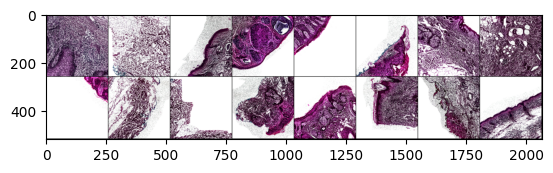

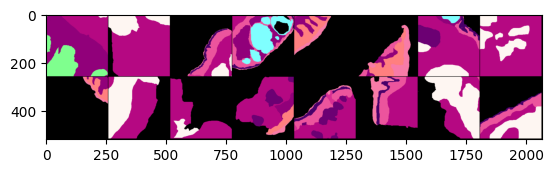

In [ ]:
for idx, (real, label) in enumerate(train_loader):
  if idx == 1:
    show_tensor(real, channel=3, size=(256, 256), num=16)
    show_tensor(label, channel=3, size=(256, 256), num=16)

#### **Training**

In [ ]:
def train(gen, disc, opt_gen, opt_disc, loader, bce, l1, g_scaler, d_scaler):
  loop = tqdm(loader, leave=True)
  for batch_idx, (x, y) in enumerate(loop):
    x, y = x.to(config.DEVICE), y.to(config.DEVICE)

    # Traing Discriminator
    with torch.cuda.amp.autocast():
      y_fake = gen(x)
      D_real = disc(x, y)
      D_fake = disc(x, y_fake.detach())
      lossD_real = bce(D_real, torch.ones_like(D_real))
      lossD_fake = bce(D_fake, torch.zeros_like(D_fake))
      lossD = (lossD_real + lossD_fake) / 2

    disc.zero_grad()
    d_scaler.scale(lossD).backward()
    d_scaler.step(opt_disc)
    d_scaler.update()

    # Train Generator
    with torch.cuda.amp.autocast():
      output = disc(x, y_fake)
      main_gen_loss = bce(output, torch.ones_like(output))
      l1_loss = l1(y_fake, y) * config.L1_LAMBDA
      lossG = main_gen_loss + l1_loss

    gen.zero_grad()
    g_scaler.scale(lossG).backward()
    g_scaler.step(opt_gen)
    g_scaler.update()


def main():
  disc = Discriminator().to(config.DEVICE)
  gen = Generator().to(config.DEVICE)
  opt_disc = optim.Adam(disc.parameters(), lr=config.LEARNING_RATE, betas=(0.5, 0.999))
  opt_gen = optim.Adam(gen.parameters(), lr=config.LEARNING_RATE, betas=(0.5, 0.999))
  BCE = nn.BCEWithLogitsLoss()
  L1_LOSS = nn.L1Loss()

  if config.LOAD_MODEL:
    utils.load_checkpoints(config.CHECKPOINT_DISC, disc, opt_disc, config.LEARNING_RATE)
    utils.load_checkpoints(config.CHECKPOINT_GEN, gen, opt_gen, config.LEARNING_RATE)

  train_dataset = MapDataset(non_melanoma_data[:1300, :, :, :])
  train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=config.NUM_WORKERS)
  val_dataset = MapDataset(non_melanoma_data[1300:, :, :, :])
  val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

  # Mixed Precision Training:
  g_scaler = torch.cuda.amp.GradScaler()
  d_scaler = torch.cuda.amp.GradScaler()

  for epoch in range(200):
    print(f"--> Epoch {epoch}:")
    train(gen, disc, opt_gen, opt_disc, train_loader, BCE, L1_LOSS, g_scaler, d_scaler)

    if config.SAVE_MODEL and epoch % 150 == 0 and epoch > 0:
      utils.save_checkpoint(gen, opt_gen, filename=config.CHECKPOINT_GEN)
      utils.save_checkpoint(disc, opt_disc, filename=config.CHECKPOINT_DISC)

    utils.save_some_examples(gen, val_loader, epoch, folder="/content/drive/MyDrive/pix2pix/evaluation_pix2pix/")

In [ ]:
main()

--> Epoch 0:


100%|██████████| 82/82 [00:15<00:00,  5.31it/s]


--> Epoch 1:


100%|██████████| 82/82 [00:15<00:00,  5.26it/s]


--> Epoch 2:


100%|██████████| 82/82 [00:15<00:00,  5.41it/s]


--> Epoch 3:


100%|██████████| 82/82 [00:15<00:00,  5.44it/s]


--> Epoch 4:


100%|██████████| 82/82 [00:15<00:00,  5.44it/s]


--> Epoch 5:


100%|██████████| 82/82 [00:15<00:00,  5.42it/s]


--> Epoch 6:


100%|██████████| 82/82 [00:15<00:00,  5.43it/s]


--> Epoch 7:


100%|██████████| 82/82 [00:15<00:00,  5.42it/s]


--> Epoch 8:


100%|██████████| 82/82 [00:15<00:00,  5.43it/s]


--> Epoch 9:


100%|██████████| 82/82 [00:15<00:00,  5.40it/s]


--> Epoch 10:


100%|██████████| 82/82 [00:15<00:00,  5.44it/s]


--> Epoch 11:


100%|██████████| 82/82 [00:15<00:00,  5.42it/s]


--> Epoch 12:


100%|██████████| 82/82 [00:14<00:00,  5.47it/s]


--> Epoch 13:


100%|██████████| 82/82 [00:15<00:00,  5.43it/s]


--> Epoch 14:


100%|██████████| 82/82 [00:15<00:00,  5.44it/s]


--> Epoch 15:


100%|██████████| 82/82 [00:15<00:00,  5.45it/s]


--> Epoch 16:


100%|██████████| 82/82 [00:15<00:00,  5.44it/s]


--> Epoch 17:


100%|██████████| 82/82 [00:15<00:00,  5.43it/s]


--> Epoch 18:


100%|██████████| 82/82 [00:15<00:00,  5.45it/s]


--> Epoch 19:


100%|██████████| 82/82 [00:15<00:00,  5.43it/s]


--> Epoch 20:


100%|██████████| 82/82 [00:15<00:00,  5.41it/s]


--> Epoch 21:


100%|██████████| 82/82 [00:15<00:00,  5.43it/s]


--> Epoch 22:


100%|██████████| 82/82 [00:15<00:00,  5.44it/s]


--> Epoch 23:


100%|██████████| 82/82 [00:15<00:00,  5.43it/s]


--> Epoch 24:


100%|██████████| 82/82 [00:15<00:00,  5.47it/s]


--> Epoch 25:


100%|██████████| 82/82 [00:15<00:00,  5.45it/s]


--> Epoch 26:


100%|██████████| 82/82 [00:14<00:00,  5.47it/s]


--> Epoch 27:


100%|██████████| 82/82 [00:15<00:00,  5.45it/s]


--> Epoch 28:


100%|██████████| 82/82 [00:15<00:00,  5.44it/s]


--> Epoch 29:


100%|██████████| 82/82 [00:15<00:00,  5.43it/s]


--> Epoch 30:


100%|██████████| 82/82 [00:15<00:00,  5.43it/s]


--> Epoch 31:


100%|██████████| 82/82 [00:15<00:00,  5.46it/s]


--> Epoch 32:


100%|██████████| 82/82 [00:15<00:00,  5.46it/s]


--> Epoch 33:


100%|██████████| 82/82 [00:15<00:00,  5.44it/s]


--> Epoch 34:


100%|██████████| 82/82 [00:14<00:00,  5.48it/s]


--> Epoch 35:


100%|██████████| 82/82 [00:15<00:00,  5.43it/s]


--> Epoch 36:


100%|██████████| 82/82 [00:14<00:00,  5.50it/s]


--> Epoch 37:


100%|██████████| 82/82 [00:15<00:00,  5.43it/s]


--> Epoch 38:


100%|██████████| 82/82 [00:15<00:00,  5.44it/s]


--> Epoch 39:


100%|██████████| 82/82 [00:15<00:00,  5.42it/s]


--> Epoch 40:


100%|██████████| 82/82 [00:14<00:00,  5.47it/s]


--> Epoch 41:


100%|██████████| 82/82 [00:15<00:00,  5.45it/s]


--> Epoch 42:


100%|██████████| 82/82 [00:15<00:00,  5.45it/s]


--> Epoch 43:


100%|██████████| 82/82 [00:15<00:00,  5.44it/s]


--> Epoch 44:


100%|██████████| 82/82 [00:15<00:00,  5.46it/s]


--> Epoch 45:


100%|██████████| 82/82 [00:15<00:00,  5.45it/s]


--> Epoch 46:


100%|██████████| 82/82 [00:15<00:00,  5.43it/s]


--> Epoch 47:


100%|██████████| 82/82 [00:15<00:00,  5.43it/s]


--> Epoch 48:


100%|██████████| 82/82 [00:15<00:00,  5.43it/s]


--> Epoch 49:


100%|██████████| 82/82 [00:15<00:00,  5.43it/s]


--> Epoch 50:


100%|██████████| 82/82 [00:14<00:00,  5.50it/s]


--> Epoch 51:


100%|██████████| 82/82 [00:15<00:00,  5.44it/s]


--> Epoch 52:


100%|██████████| 82/82 [00:14<00:00,  5.48it/s]


--> Epoch 53:


100%|██████████| 82/82 [00:15<00:00,  5.45it/s]


--> Epoch 54:


100%|██████████| 82/82 [00:14<00:00,  5.47it/s]


--> Epoch 55:


100%|██████████| 82/82 [00:15<00:00,  5.45it/s]


--> Epoch 56:


100%|██████████| 82/82 [00:14<00:00,  5.47it/s]


--> Epoch 57:


100%|██████████| 82/82 [00:15<00:00,  5.44it/s]


--> Epoch 58:


100%|██████████| 82/82 [00:15<00:00,  5.44it/s]


--> Epoch 59:


100%|██████████| 82/82 [00:15<00:00,  5.45it/s]


--> Epoch 60:


100%|██████████| 82/82 [00:14<00:00,  5.49it/s]


--> Epoch 61:


100%|██████████| 82/82 [00:15<00:00,  5.43it/s]


--> Epoch 62:


100%|██████████| 82/82 [00:14<00:00,  5.49it/s]


--> Epoch 63:


100%|██████████| 82/82 [00:15<00:00,  5.45it/s]


--> Epoch 64:


100%|██████████| 82/82 [00:15<00:00,  5.45it/s]


--> Epoch 65:


100%|██████████| 82/82 [00:15<00:00,  5.43it/s]


--> Epoch 66:


100%|██████████| 82/82 [00:15<00:00,  5.45it/s]


--> Epoch 67:


100%|██████████| 82/82 [00:15<00:00,  5.44it/s]


--> Epoch 68:


100%|██████████| 82/82 [00:15<00:00,  5.46it/s]


--> Epoch 69:


100%|██████████| 82/82 [00:15<00:00,  5.44it/s]


--> Epoch 70:


100%|██████████| 82/82 [00:15<00:00,  5.44it/s]


--> Epoch 71:


100%|██████████| 82/82 [00:15<00:00,  5.41it/s]


--> Epoch 72:


100%|██████████| 82/82 [00:15<00:00,  5.42it/s]


--> Epoch 73:


100%|██████████| 82/82 [00:15<00:00,  5.41it/s]


--> Epoch 74:


100%|██████████| 82/82 [00:15<00:00,  5.44it/s]


--> Epoch 75:


100%|██████████| 82/82 [00:15<00:00,  5.45it/s]


--> Epoch 76:


100%|██████████| 82/82 [00:14<00:00,  5.47it/s]


--> Epoch 77:


100%|██████████| 82/82 [00:15<00:00,  5.40it/s]


--> Epoch 78:


100%|██████████| 82/82 [00:15<00:00,  5.44it/s]


--> Epoch 79:


100%|██████████| 82/82 [00:15<00:00,  5.45it/s]


--> Epoch 80:


100%|██████████| 82/82 [00:15<00:00,  5.47it/s]


--> Epoch 81:


100%|██████████| 82/82 [00:15<00:00,  5.47it/s]


--> Epoch 82:


100%|██████████| 82/82 [00:14<00:00,  5.48it/s]


--> Epoch 83:


100%|██████████| 82/82 [00:14<00:00,  5.47it/s]


--> Epoch 84:


100%|██████████| 82/82 [00:15<00:00,  5.45it/s]


--> Epoch 85:


100%|██████████| 82/82 [00:15<00:00,  5.44it/s]


--> Epoch 86:


100%|██████████| 82/82 [00:15<00:00,  5.47it/s]


--> Epoch 87:


100%|██████████| 82/82 [00:15<00:00,  5.41it/s]


--> Epoch 88:


100%|██████████| 82/82 [00:15<00:00,  5.47it/s]


--> Epoch 89:


100%|██████████| 82/82 [00:15<00:00,  5.44it/s]


--> Epoch 90:


100%|██████████| 82/82 [00:15<00:00,  5.42it/s]


--> Epoch 91:


100%|██████████| 82/82 [00:15<00:00,  5.46it/s]


--> Epoch 92:


100%|██████████| 82/82 [00:15<00:00,  5.44it/s]


--> Epoch 93:


100%|██████████| 82/82 [00:15<00:00,  5.41it/s]


--> Epoch 94:


100%|██████████| 82/82 [00:15<00:00,  5.45it/s]


--> Epoch 95:


100%|██████████| 82/82 [00:15<00:00,  5.46it/s]


--> Epoch 96:


100%|██████████| 82/82 [00:15<00:00,  5.45it/s]


--> Epoch 97:


100%|██████████| 82/82 [00:14<00:00,  5.47it/s]


--> Epoch 98:


100%|██████████| 82/82 [00:15<00:00,  5.45it/s]


--> Epoch 99:


100%|██████████| 82/82 [00:15<00:00,  5.46it/s]


--> Epoch 100:


100%|██████████| 82/82 [00:15<00:00,  5.44it/s]


--> Epoch 101:


100%|██████████| 82/82 [00:15<00:00,  5.46it/s]


--> Epoch 102:


100%|██████████| 82/82 [00:15<00:00,  5.44it/s]


--> Epoch 103:


100%|██████████| 82/82 [00:15<00:00,  5.44it/s]


--> Epoch 104:


100%|██████████| 82/82 [00:15<00:00,  5.44it/s]


--> Epoch 105:


100%|██████████| 82/82 [00:15<00:00,  5.42it/s]


--> Epoch 106:


100%|██████████| 82/82 [00:15<00:00,  5.41it/s]


--> Epoch 107:


100%|██████████| 82/82 [00:15<00:00,  5.46it/s]


--> Epoch 108:


100%|██████████| 82/82 [00:15<00:00,  5.47it/s]


--> Epoch 109:


100%|██████████| 82/82 [00:15<00:00,  5.46it/s]


--> Epoch 110:


100%|██████████| 82/82 [00:15<00:00,  5.45it/s]


--> Epoch 111:


100%|██████████| 82/82 [00:15<00:00,  5.45it/s]


--> Epoch 112:


100%|██████████| 82/82 [00:15<00:00,  5.43it/s]


--> Epoch 113:


100%|██████████| 82/82 [00:15<00:00,  5.44it/s]


--> Epoch 114:


100%|██████████| 82/82 [00:15<00:00,  5.45it/s]


--> Epoch 115:


100%|██████████| 82/82 [00:15<00:00,  5.43it/s]


--> Epoch 116:


100%|██████████| 82/82 [00:15<00:00,  5.47it/s]


--> Epoch 117:


100%|██████████| 82/82 [00:15<00:00,  5.47it/s]


--> Epoch 118:


100%|██████████| 82/82 [00:15<00:00,  5.46it/s]


--> Epoch 119:


100%|██████████| 82/82 [00:15<00:00,  5.46it/s]


--> Epoch 120:


100%|██████████| 82/82 [00:15<00:00,  5.46it/s]


--> Epoch 121:


100%|██████████| 82/82 [00:15<00:00,  5.44it/s]


--> Epoch 122:


100%|██████████| 82/82 [00:15<00:00,  5.44it/s]


--> Epoch 123:


100%|██████████| 82/82 [00:15<00:00,  5.42it/s]


--> Epoch 124:


100%|██████████| 82/82 [00:15<00:00,  5.43it/s]


--> Epoch 125:


100%|██████████| 82/82 [00:15<00:00,  5.45it/s]


--> Epoch 126:


100%|██████████| 82/82 [00:15<00:00,  5.45it/s]


--> Epoch 127:


100%|██████████| 82/82 [00:15<00:00,  5.42it/s]


--> Epoch 128:


100%|██████████| 82/82 [00:15<00:00,  5.42it/s]


--> Epoch 129:


100%|██████████| 82/82 [00:15<00:00,  5.43it/s]


--> Epoch 130:


100%|██████████| 82/82 [00:15<00:00,  5.42it/s]


--> Epoch 131:


100%|██████████| 82/82 [00:15<00:00,  5.46it/s]


--> Epoch 132:


100%|██████████| 82/82 [00:14<00:00,  5.51it/s]


--> Epoch 133:


100%|██████████| 82/82 [00:14<00:00,  5.47it/s]


--> Epoch 134:


100%|██████████| 82/82 [00:15<00:00,  5.45it/s]


--> Epoch 135:


100%|██████████| 82/82 [00:15<00:00,  5.45it/s]


--> Epoch 136:


100%|██████████| 82/82 [00:15<00:00,  5.45it/s]


--> Epoch 137:


100%|██████████| 82/82 [00:14<00:00,  5.48it/s]


--> Epoch 138:


100%|██████████| 82/82 [00:15<00:00,  5.45it/s]


--> Epoch 139:


100%|██████████| 82/82 [00:14<00:00,  5.47it/s]


--> Epoch 140:


100%|██████████| 82/82 [00:15<00:00,  5.43it/s]


--> Epoch 141:


100%|██████████| 82/82 [00:14<00:00,  5.47it/s]


--> Epoch 142:


100%|██████████| 82/82 [00:15<00:00,  5.47it/s]


--> Epoch 143:


100%|██████████| 82/82 [00:14<00:00,  5.47it/s]


--> Epoch 144:


100%|██████████| 82/82 [00:14<00:00,  5.48it/s]


--> Epoch 145:


100%|██████████| 82/82 [00:14<00:00,  5.54it/s]


--> Epoch 146:


100%|██████████| 82/82 [00:14<00:00,  5.55it/s]


--> Epoch 147:


100%|██████████| 82/82 [00:14<00:00,  5.56it/s]


--> Epoch 148:


100%|██████████| 82/82 [00:14<00:00,  5.55it/s]


--> Epoch 149:


100%|██████████| 82/82 [00:14<00:00,  5.55it/s]


--> Epoch 150:


100%|██████████| 82/82 [00:14<00:00,  5.56it/s]


=> Saving checkpoints
=> Saving checkpoints
--> Epoch 151:


100%|██████████| 82/82 [00:15<00:00,  5.47it/s]


--> Epoch 152:


100%|██████████| 82/82 [00:14<00:00,  5.55it/s]


--> Epoch 153:


100%|██████████| 82/82 [00:14<00:00,  5.57it/s]


--> Epoch 154:


100%|██████████| 82/82 [00:14<00:00,  5.59it/s]


--> Epoch 155:


100%|██████████| 82/82 [00:14<00:00,  5.59it/s]


--> Epoch 156:


100%|██████████| 82/82 [00:14<00:00,  5.58it/s]


--> Epoch 157:


100%|██████████| 82/82 [00:14<00:00,  5.60it/s]


--> Epoch 158:


100%|██████████| 82/82 [00:14<00:00,  5.56it/s]


--> Epoch 159:


100%|██████████| 82/82 [00:14<00:00,  5.57it/s]


--> Epoch 160:


100%|██████████| 82/82 [00:14<00:00,  5.57it/s]


--> Epoch 161:


100%|██████████| 82/82 [00:14<00:00,  5.56it/s]


--> Epoch 162:


100%|██████████| 82/82 [00:14<00:00,  5.54it/s]


--> Epoch 163:


100%|██████████| 82/82 [00:14<00:00,  5.54it/s]


--> Epoch 164:


100%|██████████| 82/82 [00:14<00:00,  5.52it/s]


--> Epoch 165:


100%|██████████| 82/82 [00:15<00:00,  5.46it/s]


--> Epoch 166:


100%|██████████| 82/82 [00:15<00:00,  5.46it/s]


--> Epoch 167:


100%|██████████| 82/82 [00:14<00:00,  5.53it/s]


--> Epoch 168:


100%|██████████| 82/82 [00:14<00:00,  5.54it/s]


--> Epoch 169:


100%|██████████| 82/82 [00:14<00:00,  5.54it/s]


--> Epoch 170:


100%|██████████| 82/82 [00:14<00:00,  5.55it/s]


--> Epoch 171:


100%|██████████| 82/82 [00:14<00:00,  5.55it/s]


--> Epoch 172:


100%|██████████| 82/82 [00:14<00:00,  5.57it/s]


--> Epoch 173:


100%|██████████| 82/82 [00:14<00:00,  5.53it/s]


--> Epoch 174:


100%|██████████| 82/82 [00:14<00:00,  5.53it/s]


--> Epoch 175:


100%|██████████| 82/82 [00:14<00:00,  5.53it/s]


--> Epoch 176:


100%|██████████| 82/82 [00:14<00:00,  5.56it/s]


--> Epoch 177:


100%|██████████| 82/82 [00:14<00:00,  5.54it/s]


--> Epoch 178:


100%|██████████| 82/82 [00:14<00:00,  5.53it/s]


--> Epoch 179:


100%|██████████| 82/82 [00:14<00:00,  5.48it/s]


--> Epoch 180:


100%|██████████| 82/82 [00:14<00:00,  5.47it/s]


--> Epoch 181:


100%|██████████| 82/82 [00:14<00:00,  5.50it/s]


--> Epoch 182:


100%|██████████| 82/82 [00:14<00:00,  5.54it/s]


--> Epoch 183:


100%|██████████| 82/82 [00:14<00:00,  5.56it/s]


--> Epoch 184:


100%|██████████| 82/82 [00:14<00:00,  5.56it/s]


--> Epoch 185:


100%|██████████| 82/82 [00:14<00:00,  5.56it/s]


--> Epoch 186:


100%|██████████| 82/82 [00:14<00:00,  5.54it/s]


--> Epoch 187:


100%|██████████| 82/82 [00:14<00:00,  5.54it/s]


--> Epoch 188:


100%|██████████| 82/82 [00:14<00:00,  5.55it/s]


--> Epoch 189:


100%|██████████| 82/82 [00:14<00:00,  5.53it/s]


--> Epoch 190:


100%|██████████| 82/82 [00:14<00:00,  5.52it/s]


--> Epoch 191:


100%|██████████| 82/82 [00:14<00:00,  5.54it/s]


--> Epoch 192:


100%|██████████| 82/82 [00:14<00:00,  5.48it/s]


--> Epoch 193:


100%|██████████| 82/82 [00:15<00:00,  5.46it/s]


--> Epoch 194:


100%|██████████| 82/82 [00:14<00:00,  5.51it/s]


--> Epoch 195:


100%|██████████| 82/82 [00:14<00:00,  5.56it/s]


--> Epoch 196:


100%|██████████| 82/82 [00:14<00:00,  5.55it/s]


--> Epoch 197:


100%|██████████| 82/82 [00:14<00:00,  5.57it/s]


--> Epoch 198:


100%|██████████| 82/82 [00:14<00:00,  5.55it/s]


--> Epoch 199:


100%|██████████| 82/82 [00:14<00:00,  5.53it/s]


### **Pix2Pix Generative Adversarial Network (Pix2pix GAN)**

* `Discriminator: ` Patch-GAN
* `Generator: ` Attention U-net

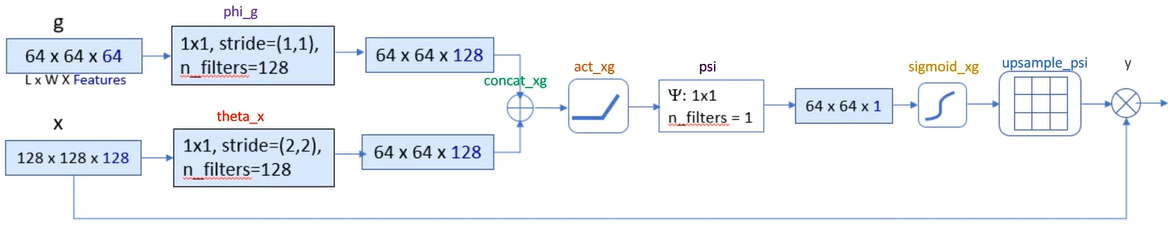

In [ ]:
class ATT_Block(nn.Module):
  def __init__(self, x_features, g_features, mid_features):
    super(ATT_Block, self).__init__()
    self.phi_g = nn.Sequential(
      nn.Conv2d(g_features, mid_features, kernel_size=1, stride=1, padding=0, bias=True),
      nn.BatchNorm2d(mid_features)
    )
    self.theta_x = nn.Sequential(
      nn.Conv2d(x_features, mid_features, kernel_size=1, stride=2, padding=0, bias=True),
      nn.BatchNorm2d(mid_features)
    )
    self.psi = nn.Sequential(
        nn.Conv2d(mid_features, 1, kernel_size=1, stride=1, padding=0, bias=True),
        nn.BatchNorm2d(1),
        nn.Sigmoid()
    )
    self.relu = nn.ReLU(inplace=True)
    self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)

    # Adding the Final 1x1 Convolution -
    self.final_conv = nn.Sequential(
        nn.Conv2d(x_features, x_features, kernel_size=1, stride=1, padding='same', bias=True),
        nn.BatchNorm2d(x_features)
    )

  def forward(self, x, g):
    g_1 = self.phi_g(g)
    print(f'g: {g_1.size()}')
    x_1 = self.theta_x(x)
    print(f'x: {x_1.size()}')
    concat_xg = self.relu(g_1 + x_1)
    print(f'concat_xg: {concat_xg.size()}')
    psi = self.psi(concat_xg)
    print(f'psi: {psi.size()}')
    upsample_psi = self.upsample(psi)
    print(f'Attention weights: {upsample_psi.size()}')
    mult = torch.mul(x, upsample_psi)
    print(f'mult: {mult.size()}')

    return self.final_conv(mult)

In [ ]:
# Testing - Attention Gate
x = torch.randn(1, 128, 128, 128)
g = torch.randn(1, 64, 64, 64)
attention_test = ATT_Block(128, 64, 128)

var = attention_test(x, g)
print(f'Final Shape: {var.shape}')

g: torch.Size([1, 128, 64, 64])
x: torch.Size([1, 128, 64, 64])
concat_xg: torch.Size([1, 128, 64, 64])
psi: torch.Size([1, 1, 64, 64])
Attention weights: torch.Size([1, 1, 128, 128])
mult: torch.Size([1, 128, 128, 128])
Final Shape: torch.Size([1, 128, 128, 128])
